In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from threeML import *
import numpy as np
from threeML.plugins import *
from skylab.datasets import Datasets
from astropy import units as u
from imp import reload
import scipy.optimize
import mla.core
import mla.injection
import mla.spectral
import warnings
warnings.filterwarnings("ignore")
import numpy.lib.recfunctions as rf
import os, sys, glob, abc

def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data
sample, season = 'GFU', 'IC86, 2011-2018'
d = Datasets[sample]
d.set_repository_path("/data/i3store/users/mjlarson/")

exp, mc, livetime = d.season(season, compress=False)
grl = d.grl(season)
sinDec_bins = d.sinDec_bins(season)
energy_bins = d.energy_bins(season)
# Where is the dataset stored?
exp=rf.append_fields(exp.copy(),
                           'angErr',
                           exp['sigma'],
                           dtypes=np.float32)
mc=rf.append_fields(mc.copy(),
                           'angErr',
                           mc['sigma'],
                           dtypes=np.float32)
exp=rf.append_fields(exp.copy(),
                           'sinDec',
                           np.sin(exp['dec']),
                           dtypes=np.float32)
mc=rf.append_fields(mc.copy(),
                           'sinDec',
                           np.sin(mc['dec']),
                           dtypes=np.float32)


Bad key "text.kerning_factor" on line 4 in
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/data/disk01/home/jasonfan/threeML/threeML/__init__.py:12: UserWarning: No DISPLAY variable set. Using backend for graphics without display (Agg)
  warnings.warn("No DISPLAY variable set. Using backend for graphics without display (Agg)")
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/parameter.py:555: UserWarning: We have set the min_value of K to 1e-99 because there was a postive transform
  warnings.warn('We have set the min_value of %s to 1e-99 because there was a postive transform' % self.path)
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/paramet

In [2]:
# testmla=mla.core.LLH_point_source(np.radians(83.63) ,np.radians(22.0145) , exp[:5] , mc, "PowerLaw", background = exp , \
#                               background_time_profile = (56224,56324),fit_position=True
#                                   ,file_name="testprecomputed")

In [3]:
testmla=mla.core.LLH_point_source(np.radians(83.63) ,np.radians(45) , exp[:5] , mc, "PowerLaw", background = exp , \
                              background_time_profile = (56224,56324),fit_position=False,gamma_points = np.arange(-4, -1, 0.1), bkg_2dbins=[sinDec_bins,energy_bins] )

In [4]:
sp=mla.spectral.PowerLaw(1e3 , 1e-9 , -2)
injector=mla.injection.PSinjector(sp,mc,background_time_profile = (56224,56324))
injector.set_backround(exp,grl,background_window=100)
injector.set_source_location(np.radians(83.63) ,np.radians(45) )


In [5]:
test=injector.sample_nevents(10000)

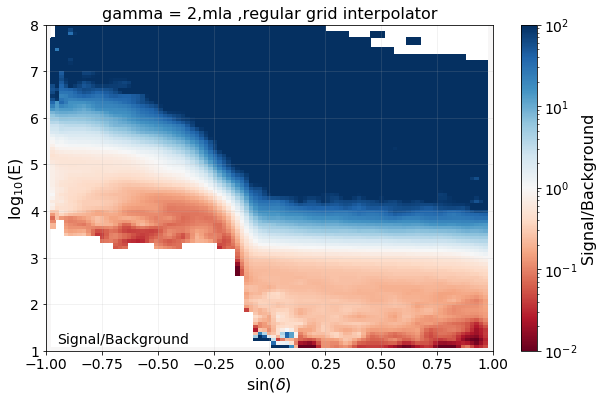

In [6]:
from matplotlib import pyplot as plt, colors
fig, ax = plt.subplots(figsize=(10,6))
sindec=np.linspace(-1,1,100)
logE=np.linspace(1,8,100)
ratio = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        ratio[i][j] = np.exp(testmla.ratio[20]([sindec[i],logE[j]]))
cmesh = ax.pcolormesh(np.linspace(-1,1,100), np.linspace(1,8,100), ratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,mla ,regular grid interpolator", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)
#np.save("mla_ratio.npy",ratio.T)

In [7]:
in_ns=np.arange(5,101)
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        testmla.update_data(injector.draw_data())
        testmla.modify_injection(injector.sample_nevents(ns))
        useless=testmla.eval_llh_fit()
        tempresult=testmla.get_fit_result()
        result.append((inject_ns,tempresult[0],tempresult[1],tempresult[2]))
    return np.array(result)

In [8]:
testmla.data

masked_array(data=[],
             mask=[],
       fill_value=(999999, 999999, 999999, 1.e+20, 1.e+20, 1.e+20, 1.e+20, 1.e+20, 1.e+20, 1.e+20, 1.e+20, 1.e+20, 1.e+20),
            dtype=[('run', '<u4'), ('event', '<u4'), ('subevent', '<u4'), ('time', '<f8'), ('azimuth', '<f8'), ('zenith', '<f8'), ('ra', '<f8'), ('dec', '<f8'), ('sigma', '<f8'), ('logE', '<f8'), ('bdtScore', '<f8'), ('angErr', '<f4'), ('sinDec', '<f4')])

In [9]:


from multiprocessing import Pool
p=Pool(30)
allresult=p.map(injectns,in_ns)
allresult=np.array(allresult)
np.save("allresult_new.npy",allresult)
p.close()

Process ForkPoolWorker-27:
Process ForkPoolWorker-28:
Process ForkPoolWorker-30:
Traceback (most recent call last):
Process ForkPoolWorker-20:
Process ForkPoolWorker-4:
Process ForkPoolWorker-11:
Process ForkPoolWorker-19:
Process ForkPoolWorker-15:
Process ForkPoolWorker-18:
Process ForkPoolWorker-26:
Process ForkPoolWorker-3:
Process ForkPoolWorker-24:
Process ForkPoolWorker-1:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Process ForkPoolWorker-22:
Process ForkPoolWorker-13:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Process ForkPoolWorker-23:
Traceback (most recent call last):
Process ForkPoolWorker-25:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py", line 582, in splev
    c[0][0]
Process ForkPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-10:
Traceba

KeyboardInterrupt: 

  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 300, in function_wrapper
    return function(*(wrapper_args + args))
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/scipy/optimize/slsqp.py", line 423, in _minimize_slsqp
    g = append(fprime(x), 0.0)
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/scipy/optimize/slsqp.py", line 399, in _minimize_slsqp
    fx = func(x)
  File "/data/disk01/home/jasonfan/umd_icecube_analysis_tutorial/mla/mla/core.py", line 458, in inner_ts
    e_lh_ratio = self.get_energy_sob(gamma, sob_spline)
  File "/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/scipy/optimize/slsqp.py", line 399, in _minimize_slsqp
    fx = func(x)
  File "/data/disk01/home/jasonfan/umd_icecube_analysis_tutorial/mla/mla/core.py", line 458, in inner_ts
    e_lh_ratio = self.get_energy_sob(gamma, sob_spline)
  File "/data/dis

In [ ]:
gamma_list=[]
ts_list=[]
ns_list=[]
for i in range(allresult.shape[0]):
    ns_inject=allresult[i][0][0]
    gamma=allresult[i][:,1]
    ts=(-allresult[i][:,3])
    ns=allresult[i][:,2]
    gamma_list.append(np.array([gamma.mean(),gamma.std()]))
    ts_list.append(np.array([ts.mean(),ts.std()]))
    ns_list.append(np.array([ns.mean(),ts.std()]))

    
gamma_list=np.array(gamma_list)
ts_list=np.array(ts_list)
ns_list=np.array(ns_list)

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))


ax.errorbar(in_ns, gamma_list[:,0],
            yerr=gamma_list[:,1],
            fmt='-',label="gamma=-2")


ax.hlines(-2,5,100)
ax.set_xlabel("injected ns")
ax.set_ylabel("gamma")
ax.set_title("gamma vs injected ns")
ax.legend()

In [ ]:
sp=mla.spectral.PowerLaw(1e3 , 1e-9 , -2.5)
injector=mla.injection.PSinjector(sp,mc,background_time_profile = (56224,56324))
injector.set_backround(exp,grl,background_window=100)
injector.set_source_location(np.radians(83.63) ,np.radians(22.0145) )
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        testmla.update_data(injector.draw_data())
        testmla.modify_injection(injector.sample_nevents(ns))
        useless=testmla.eval_llh_fit()
        tempresult=testmla.get_fit_result()
        result.append((inject_ns,tempresult[0],tempresult[1],tempresult[2]))
    return np.array(result)
p=Pool(30)
allresult25=p.map(injectns,in_ns)
allresult25=np.array(allresult25)
np.save("allresult2.5.npy",allresult25)
p.close()


gamma_list25=[]
ts_list25=[]
ns_list25=[]
for i in range(allresult25.shape[0]):
    ns_inject=allresult25[i][0][0]
    gamma=allresult25[i][:,1]
    ts=(-allresult25[i][:,3])
    ns=allresult25[i][:,2]
    gamma_list25.append(np.array([gamma.mean(),gamma.std()]))
    ts_list25.append(np.array([ts.mean(),ts.std()]))
    ns_list25.append(np.array([ns.mean(),ts.std()]))

    
gamma_list25=np.array(gamma_list25)
ts_list25=np.array(ts_list25)
ns_list25=np.array(ns_list25)


sp=mla.spectral.PowerLaw(1e3 , 1e-9 , -3)
injector=mla.injection.PSinjector(sp,mc,background_time_profile = (56224,56324))
injector.set_backround(exp,grl,background_window=100)
injector.set_source_location(np.radians(83.63) ,np.radians(22.0145) )
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        testmla.update_data(injector.draw_data())
        testmla.modify_injection(injector.sample_nevents(ns))
        useless=testmla.eval_llh_fit()
        tempresult=testmla.get_fit_result()
        result.append((inject_ns,tempresult[0],tempresult[1],tempresult[2]))
    return np.array(result)
p=Pool(30)
allresult3=p.map(injectns,in_ns)
allresult3=np.array(allresult3)
np.save("allresult3.npy",allresult3)
p.close()


gamma_list3=[]
ts_list3=[]
ns_list3=[]
for i in range(allresult3.shape[0]):
    ns_inject=allresult3[i][0][0]
    gamma=allresult3[i][:,1]
    ts=(-allresult3[i][:,3])
    ns=allresult3[i][:,2]
    gamma_list3.append(np.array([gamma.mean(),gamma.std()]))
    ts_list3.append(np.array([ts.mean(),ts.std()]))
    ns_list3.append(np.array([ns.mean(),ts.std()]))

    
gamma_list3=np.array(gamma_list3)
ts_list3=np.array(ts_list3)
ns_list3=np.array(ns_list3)


In [ ]:
len(in_ns)

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))


ax.errorbar(in_ns, gamma_list[:,0],
            yerr=gamma_list[:,1],
            fmt='-',label="gamma=-2")


ax.hlines(-2,5,100)
ax.errorbar(in_ns, gamma_list25[:,0],
            yerr=gamma_list25[:,1],
            fmt='-',label="gamma=-2.5")
ax.hlines(-2.5,5,100)
ax.errorbar(in_ns, gamma_list3[:,0],
            yerr=gamma_list3[:,1],
            fmt='-',label="gamma=-3")
ax.hlines(-3,5,100)
ax.set_xlabel("injected ns")
ax.set_ylabel("gamma")
ax.set_title("gamma vs injected ns")
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))


ax.errorbar(in_ns, ns_list[:,0],
            yerr=ns_list[:,1],
            fmt='-',label="gamma=-2")
ax.errorbar(in_ns, ns_list25[:,0],
            yerr=ns_list25[:,1],
            fmt='-',label="gamma=-2.5")

ax.errorbar(in_ns, ns_list3[:,0],
            yerr=ns_list3[:,1],
            fmt='-',label="gamma=-3")
# ax.errorbar(in_ns, ns_list[:,0],
#             yerr=0,
#             fmt='-',label="gamma=-2")
# ax.errorbar(in_ns, ns_list25[:,0],
#             yerr=0,
#             fmt='-',label="gamma=-2.5")

# ax.errorbar(in_ns, ns_list3[:,0],
#             yerr=0,
#             fmt='-',label="gamma=-3")


x=np.linspace(5,100,1000)
ax.plot(x,x,label="y=x")
ax.set_xlabel("injected ns")
ax.set_ylabel("fitted ns")
ax.set_title("gamma=-2")
ax.legend(fontsize=16)

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))

in_ns = np.linspace(1,40,100)

ax.errorbar(in_ns, ns_list[:,0],
            yerr=0,
            fmt='-',label="gamma=-2")
ax.errorbar(in_ns, ns_list25[:,0],
            yerr=0,
            fmt='-',label="gamma=-2.5")

ax.errorbar(in_ns, ns_list3[:,0],
            yerr=0,
            fmt='-',label="gamma=-3")


x=np.linspace(5,100,1000)
ax.plot(x,x,label="y=x")
ax.set_xlabel("injected ns")
ax.set_ylabel("fitted ns")
ax.set_title("gamma=-2")
ax.legend(fontsize=16)